In [ ]:
#!pip install opendatasets
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/mlops/hw2

Mounted at /content/drive
/content/drive/MyDrive/mlops/hw2


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm






## import library
import numpy as np
import os
import random
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import shutil
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import opendatasets as od
import pandas

در کد پایین با استفاده از کتابخانه از سایت کگل دیتا دانلود کردم






In [ ]:
# od.download(
#     "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


# a list of path name from all image

In [ ]:
#/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train

#/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train
imgs_path = ['/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train/',
                '/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/test/',
                '/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/val/']

file_list_ = []
for img_path in imgs_path:
 
  file_list = glob.glob(img_path + "*")
  for i in file_list: 
    file_list_.append(i)

data = []

for class_path in file_list_:
            class_name = class_path.split("/")[-1]
            filenames = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            for img_path in filenames:
                data.append([class_path+"/"+img_path, class_name])
print("number of all data:",len(data))


number of all data: 5856


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% test
train, test = train_test_split(data, test_size=0.2)

val, test = train_test_split(test, test_size=0.5)


# train : 4684
# val : 586
# test : 586


#Visualizing data

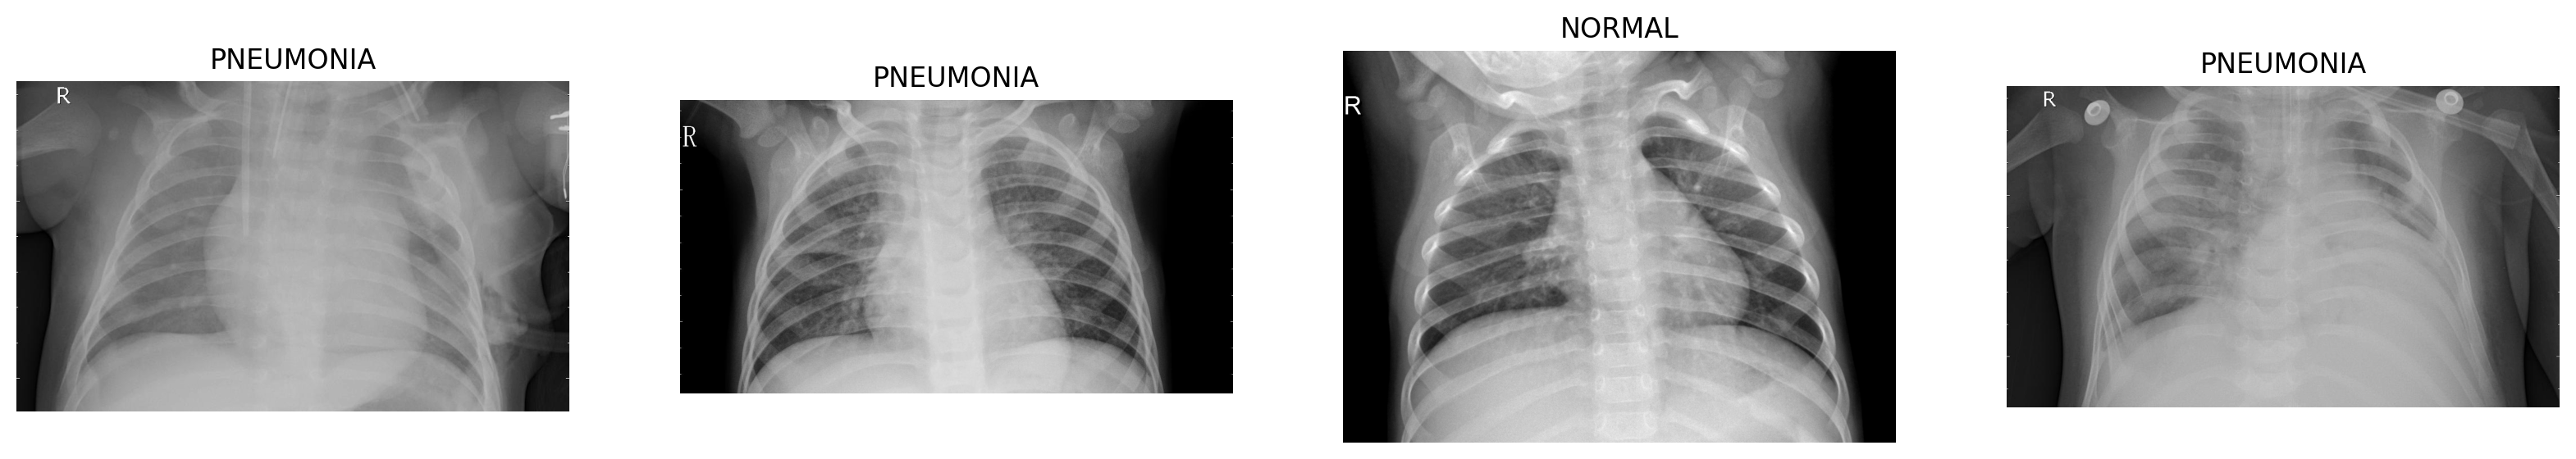

In [ ]:
i = 0 
plt.figure(figsize=(20,8))
for img_path, class_name  in train[100:104]:
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(class_name)
    i += 1
    

In [ ]:
import torchvision.transforms as T
class CustomDataset(Dataset):
    def __init__(self,data, transform):
        self.data = data
        self.class_map = {"NORMAL" : 0, "PNEUMONIA": 1}
        self.img_dim = (224, 224)

    def rotateImage(image, angle):
      row,col = (228,228)
      center=tuple(np.array([row,col])/2)
      rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
      new_image = cv2.warpAffine(image, rot_mat, (col,row))
      return new_image        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        transform = T.RandomHorizontalFlip()
        if transform is True:
          self.img = rotateImage(img ,random.randint(0, 30))
          self.img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          img = transform(img)
        
        else:
          self.img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        img_tensor = torch.from_numpy(img)
        class_id = self.class_map[class_name]
        '''For this conversion we use the permute function of torch,
            that allows us to change the ordering of the dimensions of a torch tensor. 
            The arguments we pass to it, correspond to the new ordering of dimensions we want.
            For example in our case, we have (Width, Height, Channels).
            (Width -> 0), (Height->1), (Channels->2)
              We want to reorder these dimensions to make channels first, therefore,
              we use img_tensor.permute(2, 0, 1), which would make the 2nd dimension first.'''
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id


     

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
batch_size = 16

dataset = CustomDataset(train,transform = True )		
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = CustomDataset(val ,transform = False)		
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = CustomDataset(test,transform = False)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Model Building
First, let’s import pre-trained resnet34. In Fine-tuning, that is the only thing we need to do whereas in Feature Extraction we need to freeze the weight.

#Feature Extraction

In [ ]:
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

From now code for both approaches will be the same.

In ResNet34, the last layer is a fully-connected layer with 1000 neurons. Since we are doing binary classification we will alter the final layer to have two neurons.

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion.to(device)
x = nn.Sigmoid()

In [ ]:
# Define early stopping criteria
patience = 5
min_delta = 0.01

#Model Training

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
best_loss = float('inf')
best_model_weights = None
early_stop_count = 0

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    y_true = []
    y_pred = []
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 15)

    # Train model
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        outputs = x(outputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader) 
    print('epoch_loss: ', epoch_loss)
    # Log training loss to tensorboard
    writer.add_scalar('Train Loss', epoch_loss, epoch)

    # Validation phase
    model.eval() 

    val_loss = 0.0
    
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.float())
        outputs = x(outputs)
        loss = criterion(outputs, labels.float())
        val_loss += loss.item()

        pred =torch.round(outputs.detach())
        target = torch.round(labels.detach())
        

        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())

    val_acc = accuracy_score(y_true,y_pred)  
    val_loss = val_loss / len(val_loader)
    # Log validation loss and accuracy to tensorboard
    print(f'Train Loss: {epoch_loss:.4f}\t Val Loss: {val_loss:.4f}\t Val Acc: {val_acc:.4f}')

    # Check for early stopping
    if epoch_loss < best_loss - min_delta:
      best_loss = epoch_loss
      best_model_weights = model.state_dict()
      early_stop_count = 0

    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print(f'Early stopping after {patience} epochs of no improvement')
        break

y_true = []
y_pred = []
Image_link = []
# Load the best model weights and evaluate on the test set
model.load_state_dict(best_model_weights)
model.eval()

test_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.float())
        outputs = x(outputs)
        loss = criterion(outputs, labels.float())
        pred =torch.round(outputs.detach())
        target = torch.round(labels.detach())
        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())

        if y_pred != y_true :
          Image_link.append(inputs)
        

        
        test_loss += loss.item()
test_loss = test_loss / len(test_loader)
print("Accuracy on test set is" ,accuracy_score(y_true,y_pred))



Epoch 1/2
----------
epoch_loss:  0.29272105366805307
Train Loss: 0.2927	 Val Loss: 0.1780	 Val Acc: 0.9420
Epoch 2/2
----------
epoch_loss:  0.2149102309203799
Train Loss: 0.2149	 Val Loss: 0.1632	 Val Acc: 0.9420
Accuracy on test set is 0.9334470989761092


In [ ]:
torch.save(model.state_dict(), 'saved_weights.pt')

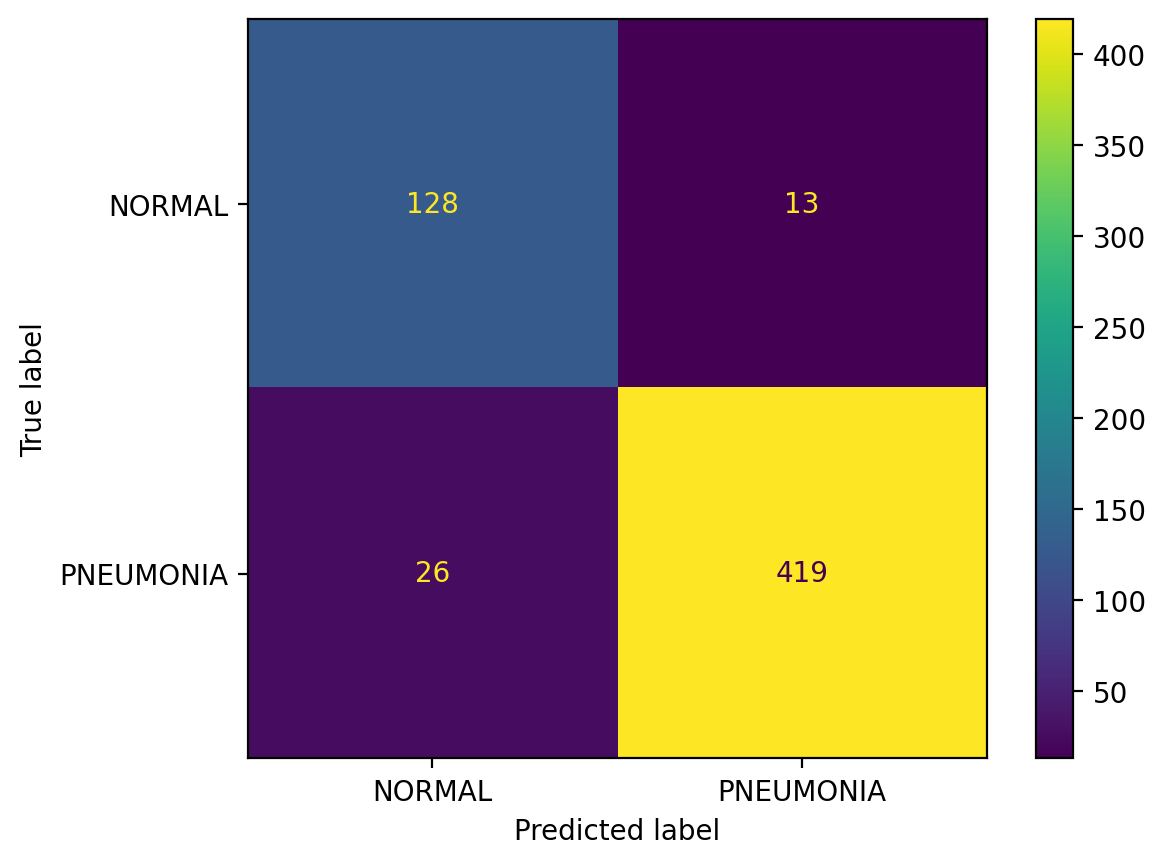

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
import matplotlib.pyplot as plt 

confusion_matrix = confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=["NORMAL","PNEUMONIA"]) 
cm_display.plot()
plt.show() 
